Assessing the Performance of Machine Learning Algorithms for Soil Classification Using Cone Penetration Test Data

# Geotech Data Preprocessing 

On this notebook, we preprocess Geotech data, from [Cone Penetration Test dataset](http://140.112.12.21/issmge/tc304.htm?=6) for Soil Classification case based on this [paper](https://www.mdpi.com/2076-3417/13/9/5758).

Soil classification holds significant importance within the field of geotechnical engineering, particularly during the assessment of a site's response to seismic events. The precise categorization of soil aids in the understanding of soil's dynamic properties and how earthquakes affect its behavior. Traditional soil classification is usually carried out based on CPT data.

For many years, the [cone penetration test (CPT)](https://www.youtube.com/watch?v=98Q9Huc9Us0) has been the primary method for conducting field exploration in geotechnical engineering. This test involves inserting a cone-shaped instrument into the soil at a consistent penetration rate and measuring the cone tip resistance (qc) and sleeve friction (fs). The CPT consistently provides results throughout its profile depth. Additionally, the CPT is a fast and cost-effective method for collecting field data to estimate parameters for various applications.

## Libraries

In [1]:
import pandas as pd # data processing
from glob import glob # filepath pattern
import math # math operation

## Read and Wrangling Data

In [2]:
# get all files name
FOLDERPATH = 'CPT_232_50_50_text/'

filenames = glob(FOLDERPATH + '*.txt')
print('number of files:', len(filenames))

number of files: 232


In [3]:
# read all files
df_list = []
for filename in filenames:
    df = pd.read_csv(filename, sep="\t", header=None)
    df_list.append(df)
print(len(df_list))

232


In [4]:
# concat all dataframe
data_concat = pd.concat(df_list)
data_concat = data_concat.reset_index(drop=True)
data_concat.columns = ['depth', 'qc', 'fs']
print('rows, columns:', data_concat.shape)

rows, columns: (229983, 3)


In [5]:
data_concat

,depth,qc,fs
0,15,3.93,5.4
1,20,5.06,5.4
2,25,5.35,9.8
3,30,5.62,9.8
4,35,5.95,11.7
...,...,...,...
229978,5022,2.29,116.8
229979,5027,2.23,116.3
229980,5032,2.24,116.3
229981,5037,2.21,118.8


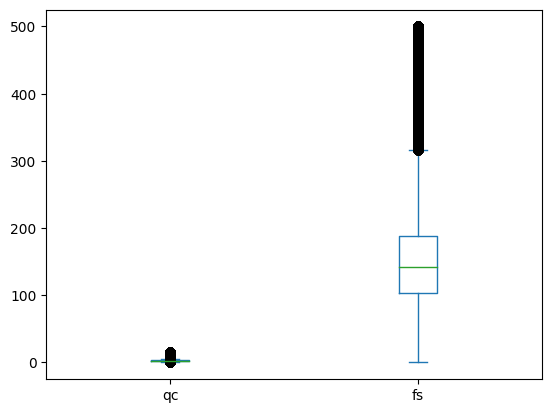

In [6]:
data_concat.plot(kind='box');

- The first column contains depth below the ground surface to the tip of the cone penetrometer, z (mm).
- The second column contains cone tip resistance values, qc (MPa).
- The third column contains sleeve friction values, fs (kPa).

The data were obtained from two sites located within the central business district of Adelaide, South Australia. The CPTs were collected from an area measuring 50 by 50 m. Each CPT was performed to a depth of 5 m below the ground surface, and the measurement spacing of qc and fs was 5 mm.

### Mising values

In [7]:
# remove missing value
data_concat.dropna(inplace=True)

In [8]:
# sanity check
data_concat.isna().sum()

depth    0
qc       0
fs       0
dtype: int64

### Data types

In [9]:
#check data types
data_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229021 entries, 0 to 229982
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   depth   229021 non-null  object 
 1   qc      229021 non-null  float64
 2   fs      229021 non-null  float64
dtypes: float64(2), object(1)
memory usage: 7.0+ MB


### Data transformation

Change the units of each variable based on the paper.

In [10]:
# change mm to m on depth column
data_concat.depth = pd.to_numeric(data_concat.depth)
data_concat.depth = data_concat.depth * 0.001
data_concat.head()

,depth,qc,fs
0,0.015,3.93,5.4
1,0.020,5.06,5.4
2,0.025,5.35,9.8
3,0.030,5.62,9.8
4,0.035,5.95,11.7


In [11]:
# change mPa to kPa on qc column
data_concat.qc = data_concat.qc * 1000
data_concat.head()

,depth,qc,fs
0,0.015,3930.0,5.4
1,0.020,5060.0,5.4
2,0.025,5350.0,9.8
3,0.030,5620.0,9.8
4,0.035,5950.0,11.7


After transformation:

- The first column contains depth below the ground surface to the tip of the cone penetrometer, z (**m**).
- The second column contains cone tip resistance values, qc (**kPa**).
- The third column contains sleeve friction values, fs (**kPa**).

### Data Outlier

Abnormal data readings during CPT operations can primarily occur due to human or procedural errors, such as the addition of a rod. These outliers are not representative of the actual CPT measurements and should be detected and removed during the data preprocessing stage.

In [12]:
data_concat.describe()

,depth,qc,fs
count,229021.000000,229021.000000,229021.000000
mean,2.531688,3035.549578,154.363791
std,1.455316,1994.829164,90.422573
min,0.000000,0.000000,0.000000
25%,1.272000,2010.000000,103.600000
50%,2.527000,2450.000000,142.700000
75%,3.786000,3200.000000,188.700000
max,5.633000,15000.000000,500.000000


In [13]:
# compute qc IQR
Q1_qc = data_concat.qc.quantile(0.25)
Q3_qc = data_concat.qc.quantile(0.75)
IQR_qc = Q3_qc - Q1_qc
print('qc IQR: ', IQR_qc)

qc IQR:  1190.0000000000002


In [14]:
# compute fs IQR
Q1_fs = data_concat.fs.quantile(0.25)
Q3_fs = data_concat.fs.quantile(0.75)
IQR_fs = Q3_fs - Q1_fs
print('fs IQR: ', IQR_fs)

fs IQR:  85.1


Determine the upper threshold values for outlier detection by multiplying the IQR by three and adding the third quartile (based on the paper)

In [15]:
# Determine the upper threshold values for outlier detection by 
# multiplying the IQR by three and adding the third quartile
upper_threshold_qc = IQR_qc * 3 + Q3_qc
print('upper threshold for qc: ', upper_threshold_qc)

upper threshold for qc:  6770.000000000001


In [16]:
# Determine the upper threshold values for outlier detection by 
# multiplying the IQR by three and adding the third quartile
upper_threshold_fs = IQR_fs * 3 + Q3_fs
print('upper threshold for fs: ', upper_threshold_fs)

upper threshold for fs:  444.0


In [17]:
# conditional subsetting for outlier values
outlier_qc = data_concat.qc >= upper_threshold_qc 
outlier_fs = data_concat.fs >= upper_threshold_fs

In [18]:
# replace the outlier values with the threshold value
data_concat.loc[outlier_qc, 'qc'] = upper_threshold_qc
data_concat.loc[outlier_fs, 'fs'] = upper_threshold_fs

print('qc max value: ', data_concat.qc.max())
print('fs max value: ', data_concat.fs.max())

qc max value:  6770.000000000001
fs max value:  444.0


In [19]:
# check zero value on qc and fs variable
data_concat[(data_concat.qc == 0) | (data_concat.fs == 0)]

,depth,qc,fs
1998,0.005,1280.0,0.0
1999,0.010,1390.0,0.0
2000,0.015,1160.0,0.0
2001,0.020,1390.0,0.0
2002,0.025,1390.0,0.0
...,...,...,...
227345,0.010,0.0,21.0
227346,0.015,0.0,19.1
227347,0.020,0.0,19.1
227348,0.025,0.0,20.0


In [20]:
# remove zero qc value
data_concat.drop(data_concat[(data_concat.qc == 0) | (data_concat.fs == 0)].index, inplace=True)

### Estimate the friction ratio (Rf)

In [21]:
Rf_formula = lambda row: row.fs/row.qc # define a function for the new column
Rf_col = data_concat.apply(Rf_formula, axis=1) # get column data with an index
data_concat = data_concat.assign(Rf=Rf_col.values) # assign values to column 'Rf'
data_concat

,depth,qc,fs,Rf
0,0.015,3930.0,5.4,0.001374
1,0.020,5060.0,5.4,0.001067
2,0.025,5350.0,9.8,0.001832
3,0.030,5620.0,9.8,0.001744
4,0.035,5950.0,11.7,0.001966
...,...,...,...,...
229978,5.022,2290.0,116.8,0.051004
229979,5.027,2230.0,116.3,0.052152
229980,5.032,2240.0,116.3,0.051920
229981,5.037,2210.0,118.8,0.053756


In [22]:
data_concat.describe()

,depth,qc,fs,Rf
count,221139.000000,221139.000000,221139.000000,221139.000000
mean,2.574564,2913.744749,159.158139,0.058250
std,1.428493,1435.893688,84.696529,0.047164
min,0.005000,10.000000,0.300000,0.000074
25%,1.357000,2040.000000,108.500000,0.044159
50%,2.569000,2480.000000,145.200000,0.059289
75%,3.798000,3240.000000,191.600000,0.071632
max,5.633000,6770.000000,444.000000,8.990000


In [23]:
# sanity check
data_concat.isna().sum()

depth    0
qc       0
fs       0
Rf       0
dtype: int64

- yg pa pake yg 100 kPa

## Robertson Classification 

Robertson classification based on lc boundaries for label/target variable. The formula we follow is based on [this paper](https://www.cpt-robertson.com/PublicationsPDF/2-56%20RobSBT.pdf).

$$lc \ formula = \sqrt{(3.47 - log(\frac{q_c}{p_a}))^2 + (log(R_f) + 1.22)^2}$$

where:

- qc = CPT cone resistance (or corrected cone resistance, qt)
- Rf = friction ratio = (fs/qc)100%
- fs = CPT sleeve friction

In [24]:
# Robertson classification based on lc boundaries

lc_formula = lambda row: math.sqrt((3.47 - math.log1p(row.qc/100))**2 + (math.log1p(row.Rf) + 1.22)**2)
lc_col = data_concat.apply(lc_formula, axis=1) # get column data with an index
data_concat = data_concat.assign(lc=lc_col.values) # assign values to column 'Rf'
data_concat

,depth,qc,fs,Rf,lc
0,0.015,3930.0,5.4,0.001374,1.242170
1,0.020,5060.0,5.4,0.001067,1.309667
2,0.025,5350.0,9.8,0.001832,1.331114
3,0.030,5620.0,9.8,0.001744,1.350951
4,0.035,5950.0,11.7,0.001966,1.376021
...,...,...,...,...,...
229978,5.022,2290.0,116.8,0.051004,1.303819
229979,5.027,2230.0,116.3,0.052152,1.310886
229980,5.032,2240.0,116.3,0.051920,1.309627
229981,5.037,2210.0,118.8,0.053756,1.314501


Soil behaviour type classification based on lc boundaries

In [25]:
# soil behaviour type classification based on lc boundaries
def label_soil_lc(row):
    '''
    Return a string value of soil type based on lc boundaries by Robertson Soil Classification
    '''
    if row.lc >= 3.6: return 'organic soil'
    if (row.lc >= 2.95) & (row.lc < 3.6): return 'clays'
    if (row.lc >= 2.6) & (row.lc < 2.95): return 'silt mixtures'
    if (row.lc >= 2.05) & (row.lc < 2.6): return 'sand mixtures'
    if (row.lc >= 1.31) & (row.lc < 2.05): return 'sands'
    else: return 'gravelly sands to dense sand'

In [26]:
data_concat["soil_type"] = data_concat.apply(label_soil_lc, axis=1)

In [27]:
data_concat.head()

,depth,qc,fs,Rf,lc,soil_type
0,0.015,3930.0,5.4,0.001374,1.242170,gravelly sands to dense sand
1,0.020,5060.0,5.4,0.001067,1.309667,gravelly sands to dense sand
2,0.025,5350.0,9.8,0.001832,1.331114,sands
3,0.030,5620.0,9.8,0.001744,1.350951,sands
4,0.035,5950.0,11.7,0.001966,1.376021,sands


In [28]:
data_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221139 entries, 0 to 229982
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   depth      221139 non-null  float64
 1   qc         221139 non-null  float64
 2   fs         221139 non-null  float64
 3   Rf         221139 non-null  float64
 4   lc         221139 non-null  float64
 5   soil_type  221139 non-null  object 
dtypes: float64(5), object(1)
memory usage: 11.8+ MB


In [29]:
# change data types 
data_concat['soil_type'] = data_concat['soil_type'].astype('category')

In [30]:
# sanity check
data_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221139 entries, 0 to 229982
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   depth      221139 non-null  float64 
 1   qc         221139 non-null  float64 
 2   fs         221139 non-null  float64 
 3   Rf         221139 non-null  float64 
 4   lc         221139 non-null  float64 
 5   soil_type  221139 non-null  category
dtypes: category(1), float64(5)
memory usage: 10.3 MB


## Exploratory Data Analysis

In [31]:
data_concat.soil_type.value_counts()

soil_type
sands                           123750
gravelly sands to dense sand     96634
sand mixtures                      536
silt mixtures                       89
clays                               79
organic soil                        51
Name: count, dtype: int64

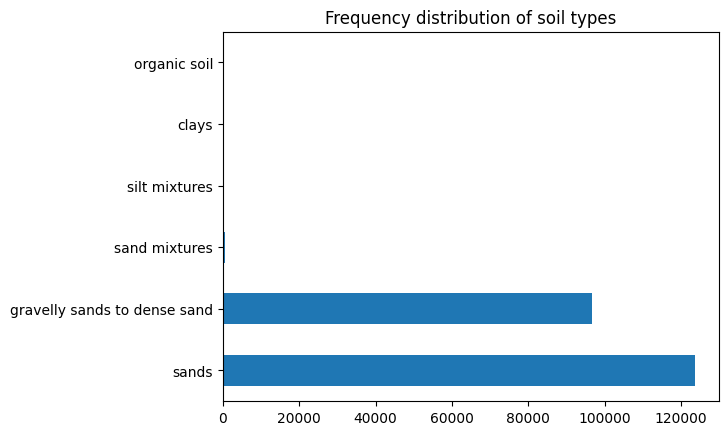

In [32]:
data_concat.soil_type.value_counts().sort_values(ascending=False).plot(kind='barh', 
                                                                       ylabel='',  
                                                                       title='Frequency distribution of soil types');

In [33]:
data_concat.describe()

,depth,qc,fs,Rf,lc
count,221139.000000,221139.000000,221139.000000,221139.000000,221139.000000
mean,2.574564,2913.744749,159.158139,0.058250,1.351768
std,1.428493,1435.893688,84.696529,0.047164,0.117381
min,0.005000,10.000000,0.300000,0.000074,1.220880
25%,1.357000,2040.000000,108.500000,0.044159,1.289250
50%,2.569000,2480.000000,145.200000,0.059289,1.318859
75%,3.798000,3240.000000,191.600000,0.071632,1.382664
max,5.633000,6770.000000,444.000000,8.990000,4.877509


In [34]:
data_concat.describe(include='category')

,soil_type
count,221139
unique,6
top,sands
freq,123750


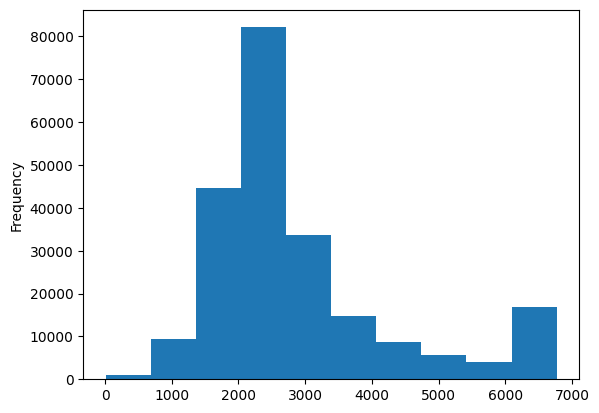

In [35]:
data_concat['qc'].plot(kind='hist');

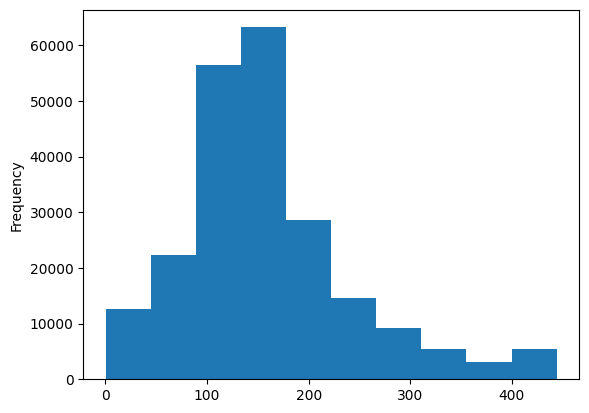

In [36]:
data_concat['fs'].plot(kind='hist');

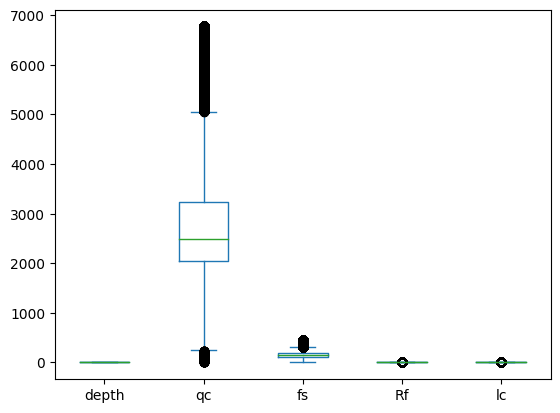

In [37]:
data_concat.plot(kind='box');

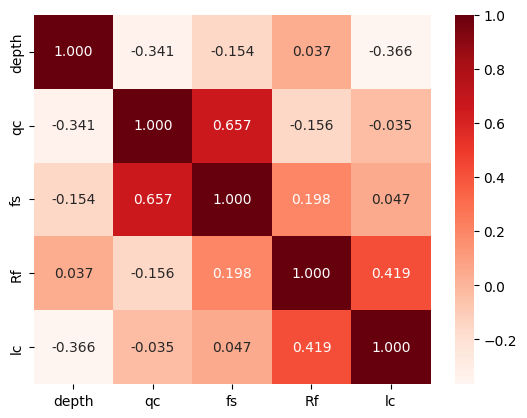

In [40]:
import seaborn as sns
sns.heatmap(data_concat.corr(numeric_only=True), # nilai korelasi
            annot=True,   # anotasi angka di dalam kotak heatmap
            fmt=".3f",    # format 3 angka dibelakang koma 
            cmap='Reds'); # warna heatmap

## Save the dataframe

In [38]:
# data_concat.to_csv('data_input/soil_behaviour_type_cpt.csv', index=False)  

Saving data to pickle format to preserve data types:

In [39]:
# data_concat.to_pickle("data_input/soil_behaviour_type_cpt.pkl")  

# References

- [Chala AT, Ray R. Assessing the Performance of Machine Learning Algorithms for Soil Classification Using Cone Penetration Test Data. Applied Sciences. 2023; 13(9):5758. https://doi.org/10.3390/app13095758](https://www.mdpi.com/2076-3417/13/9/5758)
- [Robertson P.K., Soil Behaviour Type from the CPT: an update ](https://www.cpt-robertson.com/PublicationsPDF/2-56%20RobSBT.pdf)
- [Jaksa, M. (1995). The Influence of Spatial Variability on the Geotechnical Design Properties of a Stiff, Overconsolidated Clay. Ph.D. Dissertation, University of Adelaide, Australia.](https://www.researchgate.net/publication/238346452_The_Influence_of_Spatial_Variability_on_the_Geotechnical_Design_Properties_of_a_Stiff_Overconsolidated_Clay)
- [CPT databases](http://140.112.12.21/issmge/tc304.htm?=6)